# Yield Curve Analysis with PCA

#### Load data

In [7]:
import pandas_datareader.data as web
import pandas as pd

start_date = "1982-01-01"

yields = {
    "DGS3MO": web.DataReader("DGS3MO", "fred", start=start_date),
    "DGS2":   web.DataReader("DGS2", "fred", start=start_date),
    "DGS5":   web.DataReader("DGS5", "fred", start=start_date),
    "DGS10":  web.DataReader("DGS10", "fred", start=start_date),
    "DGS30":  web.DataReader("DGS30", "fred", start=start_date),
}

yields_df = pd.concat(yields, axis=1)
yields_df = yields_df.resample("ME").mean().dropna()
yields_df.columns = ['DGS3MO', 'DGS2', 'DGS5', 'DGS10', 'DGS30']

#### PCA

In [8]:
from sklearn.decomposition import PCA
import numpy as np

# Standardize (optional: subtract mean)
X = yields_df - yields_df.mean()

pca = PCA(n_components=3)
pca.fit(X)

factors = pd.DataFrame(
    pca.transform(X),
    index=X.index,
    columns=["PC1_Level", "PC2_Slope", "PC3_Curvature"]
)
print("Explained variance ratios:", np.round(pca.explained_variance_ratio_, 3))

Explained variance ratios: [0.968 0.029 0.002]


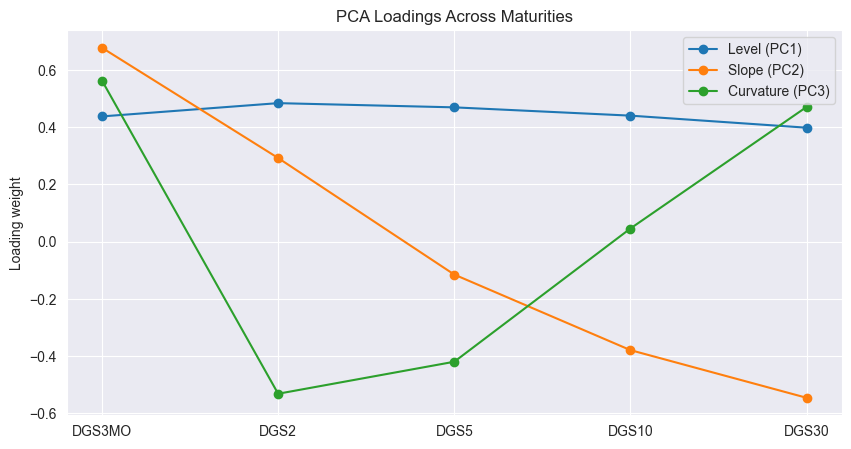

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(X.columns, pca.components_[0], marker="o", label="Level (PC1)")
plt.plot(X.columns, pca.components_[1], marker="o", label="Slope (PC2)")
plt.plot(X.columns, pca.components_[2], marker="o", label="Curvature (PC3)")
plt.title("PCA Loadings Across Maturities")
plt.ylabel("Loading weight")
plt.legend()
plt.show()

PC1 (Level): roughly flat → moves all yields together

PC2 (Slope): negative for short, positive for long → steepening/flattening

PC3 (Curvature): positive at short & long ends, negative in middle → “hump”

array([<Axes: title={'center': 'Level'}, xlabel='DATE'>,
       <Axes: title={'center': 'Slope'}, xlabel='DATE'>,
       <Axes: title={'center': 'Curvature'}, xlabel='DATE'>], dtype=object)

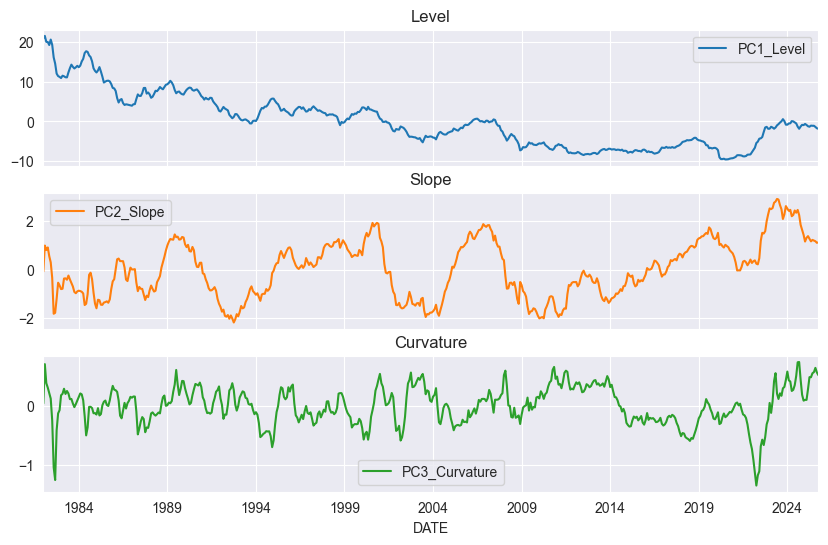

In [10]:
factors.plot(subplots=True, figsize=(10,6), title=["Level", "Slope", "Curvature"])

Interpretation:

Level: tracks long-term interest rate trends (policy + inflation expectations)

Slope: correlates strongly with 10Y–2Y spread, good recession indicator

Curvature: reflects medium-term yield movements (term premium shifts)

In [12]:
data_m = pd.read_csv("../../../data/processed/us_macro_monthly.csv", index_col=0, parse_dates=True)

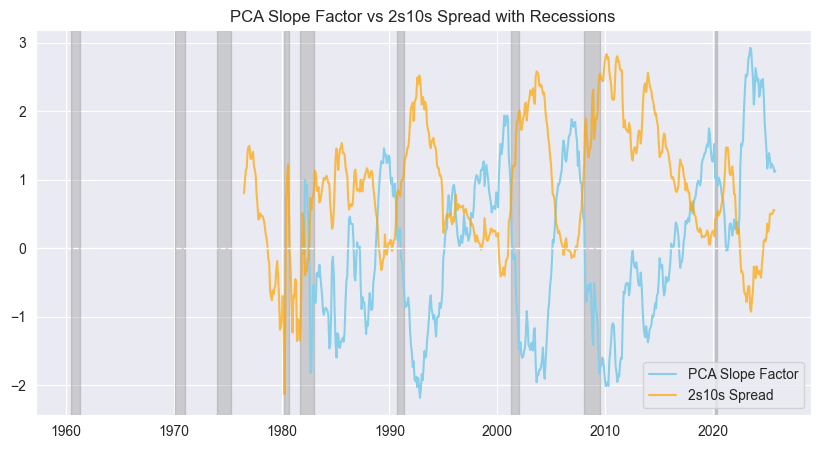

In [32]:
data_m['spread_10y_2y'] = data_m['DGS10'] - data_m['DGS2']

usrec = web.DataReader("USREC", "fred", start=data_m.index[0]).resample("ME").last()

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(factors.index, factors["PC2_Slope"], label="PCA Slope Factor", color="skyblue")
ax.plot(data_m.index, data_m["spread_10y_2y"], label="2s10s Spread", color="orange", alpha=0.7)
ax.axhline(0, color="white", linestyle="--", linewidth=1)

for i in range(1, len(usrec)):
    if usrec.iloc[i-1,0]==0 and usrec.iloc[i,0]==1:
        start = usrec.index[i]
    if usrec.iloc[i-1,0]==1 and usrec.iloc[i,0]==0:
        end = usrec.index[i]
        ax.axvspan(start, end, color='gray', alpha=0.3)

ax.set_title("PCA Slope Factor vs 2s10s Spread with Recessions")
ax.legend()
plt.show()


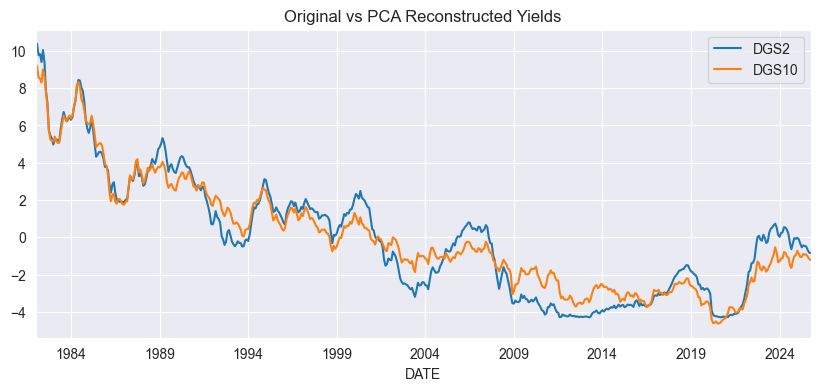

In [22]:
reconstructed = pca.inverse_transform(factors)
approx = pd.DataFrame(reconstructed, index=X.index)
approx.columns = X.columns
approx[['DGS2', 'DGS10']].plot(figsize=(10,4), title="Original vs PCA Reconstructed Yields")
plt.show()

In [33]:
factors.to_csv("../../../data/processed/yield_curve_factors.csv")